<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

-----

One of the most common applications for ARIMA models is inventory planning. In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, root
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# in case pandas & statsmodels datetime have an issue
import warnings
warnings.simplefilter(action="ignore")

### Importing and exploring the data

After importing, check the following:
- Is there any missing data?
- What are the column datatypes?
- How many observations are there?
- How many unique stores are there?
- How many unique departments are there?

In [3]:
walmart = pd.read_csv('datasets/train.csv')
walmart.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


In [4]:
walmart.isnull().sum().sort_values(ascending=False) #no nulls

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [5]:
walmart.columns #name of columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

In [6]:
walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [7]:
walmart.shape #421570 instances, 5 columns

(421570, 5)

In [8]:
#unique stores = 45 stores
walmart['Store'].nunique()

45

In [9]:
walmart['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64)

In [10]:
#unique departments = 81 departments
walmart['Dept'].nunique()

81

In [20]:
walmart['Dept'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56,
       58, 59, 60, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 90,
       91, 92, 93, 94, 95, 96, 97, 98, 99, 39, 50, 43, 65], dtype=int64)

In [22]:
walmart.head(20)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
5,1,1,2010-03-12,21043.39,False
6,1,1,2010-03-19,22136.64,False
7,1,1,2010-03-26,26229.21,False
8,1,1,2010-04-02,57258.43,False
9,1,1,2010-04-09,42960.91,False


**Creating a datetime index**

Convert the Date column to datetime, and set it as the index for the dataframe.

In [25]:
#date is an object, format in the data appears to be yyyy-mm-dd
walmart['Date'] = pd.to_datetime(walmart['Date'], yearfirst=True)

In [27]:
walmart = walmart.set_index('Date').sort_index()

In [29]:
walmart

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-05,29,5,15552.08,False
2010-02-05,29,6,3200.22,False
2010-02-05,29,7,10820.05,False
2010-02-05,29,8,20055.64,False
...,...,...,...,...
2012-10-26,40,87,24638.96,False
2012-10-26,19,30,3740.12,False
2012-10-26,19,31,3128.17,False


**Getting weekly sales for store 1**

To simplify our work somewhat, we'll consider **only** sales from store 1, and we'll aggregate sales from all departments in store 1.

Create a new dataframe that contains weekly sales for store 1.

> **Note**: You might break this up into multiple steps, or you might do this in one line.
>
> To aggregate, use **[groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html)**. We're tallying up all sales that have the same date, _not_ aggregating many dates based on year or month.
>
> The only column you'll need to keep is `Weekly_Sales`. You should get rid of the `Store`, `Dept`, and `IsHoliday` columns in your new dataframe.

In [32]:
st1 = walmart[walmart['Store'] == 1] #'Store' == 1
st1_df = walmart.groupby('Date')[['Weekly_Sales']].sum()

In [34]:
st1_df

,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30
...,...
2012-09-28,43734899.40
2012-10-05,47566639.31
2012-10-12,46128514.25


---

### Plotting and interpreting a time series

**Generate a line plot**

Generate a line plot for weekly sales, with time on the $x$-axis and sales on the $y$-axis. Make sure the plot has a title, and make sure axes are labeled where appropriate.

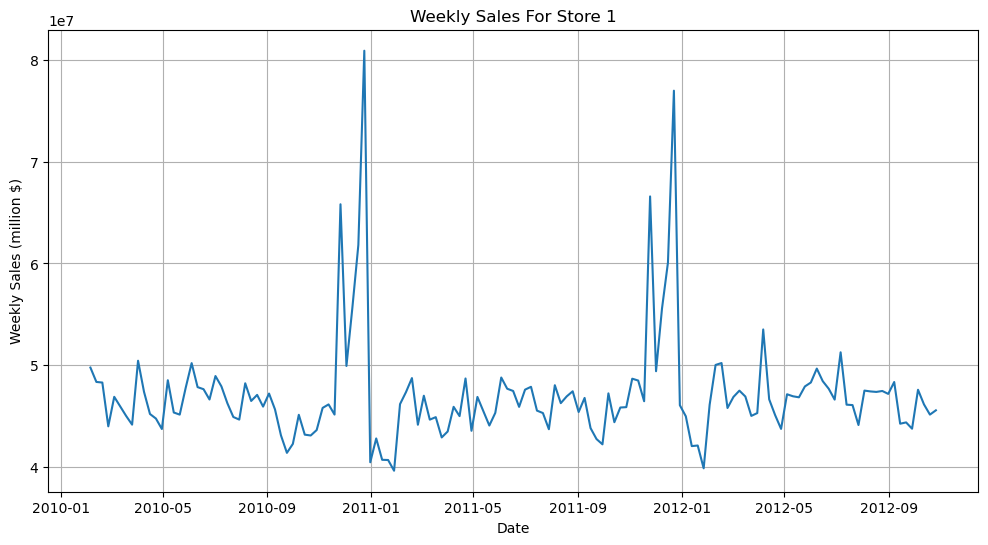

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(st1_df)

plt.title('Weekly Sales For Store 1')
plt.xlabel('Date')
plt.ylabel('Weekly Sales (million $)')
plt.grid(True);

**Plotting rolling means**

Smoothing can help us see trends in the data. On one graph, plot the following:

- Weekly sales
- The 4-week rolling mean of weekly sales
- The 13-week rolling mean of weekly sales
    - (This is included because there are 13 weeks in a business quarter!)

Make sure the plot has a title, axis labels where appropriate, and a legend.

> **(BONUS)**: Add vertical lines on the plot to indicate January 2011 and January 2012.

In [40]:
# resample for week
st1_df = st1_df.resample('W').mean()
st1_df

,Weekly_Sales
Date,
2010-02-07,49750740.50
2010-02-14,48336677.63
2010-02-21,48276993.78
2010-02-28,43968571.13
2010-03-07,46871470.30
...,...
2012-09-30,43734899.40
2012-10-07,47566639.31
2012-10-14,46128514.25


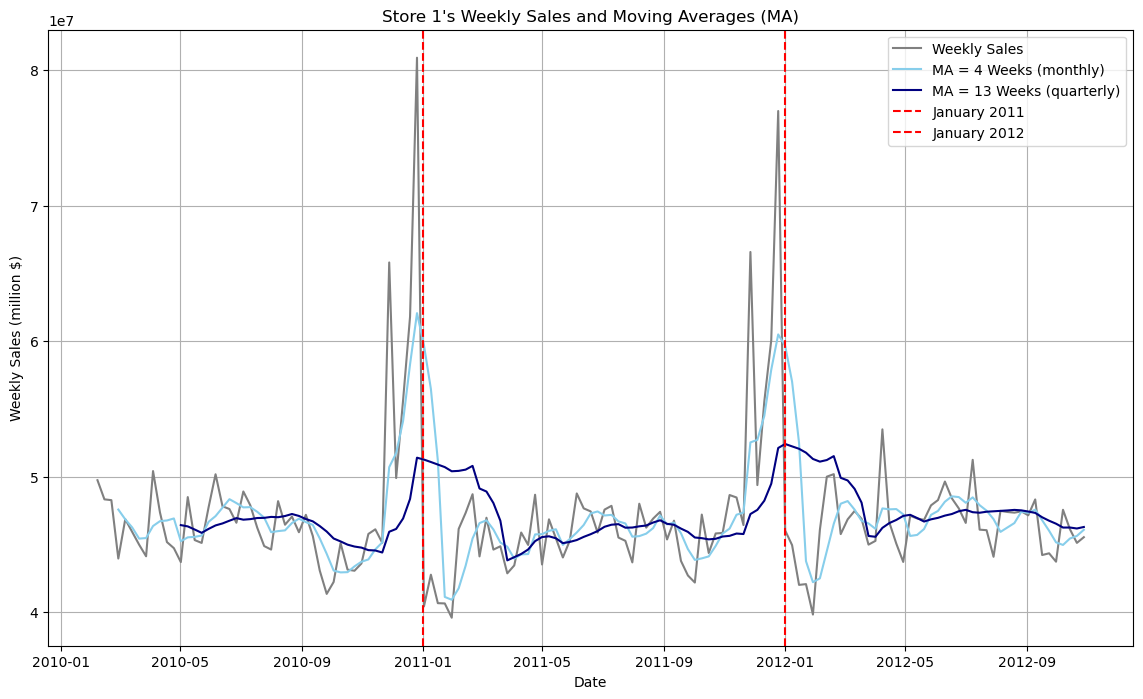

In [54]:
# plot rolling mean= 4 weeks, rolling mean = 13 weeks

plt.figure(figsize=(14, 8))
plt.plot(st1_df, color='gray', label='Weekly Sales')
plt.plot(st1_df.rolling(4).mean(), color='skyblue', label='MA = 4 Weeks (monthly)')
plt.plot(st1_df.rolling(13).mean(), color='navy', label='MA = 13 Weeks (quarterly)')
plt.axvline(pd.Timestamp('2011-01-01'), color='red', label='January 2011', ls='--')
plt.axvline(pd.Timestamp('2012-01-01'), color='red', label='January 2012', ls='--')
plt.title("Store 1's Weekly Sales and Moving Averages (MA)")
plt.xlabel('Date')
plt.ylabel('Weekly Sales (million $)')
plt.legend()
plt.grid(True)
plt.show();

**Describe any trends that you notice**

In [2]:
# A: Smoother curves (less noise) if the MA increases. 
#The peaks in January 2011 and January 2012 are less pronounced (less amplitude),
# but are still visible as peaks for the New Year in an overall apparent seasonal, cyclical pattern for weekly sales.

---

### Autocorrelation and partial autocorrelation

Recall that autocorrelation and partial autocorrelation tell us about how a variable is related to itself at previous lags.

**Plot and interpret the autocorrelation**

Use statsmodels to plot the ACF and PACF. Look at up to **52 lags**. 

What do you notice? Provide a written answer along with your ACF/PACF plots below.

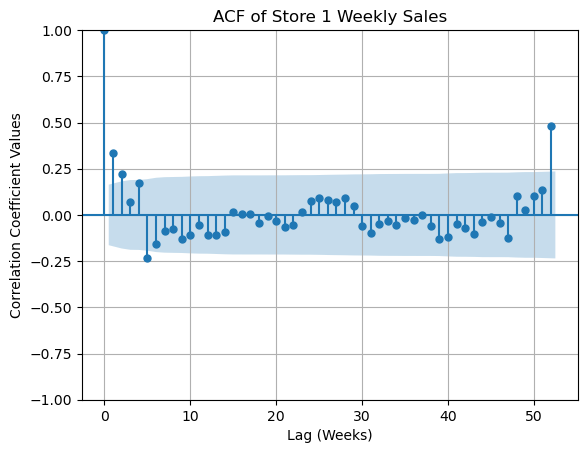

In [70]:
plot_acf(st1_df, lags=52)
plt.title("ACF of Store 1 Weekly Sales")
plt.xlabel('Lag (Weeks)')
plt.ylabel('Correlation Coefficient Values')
plt.grid(True)

In [60]:
# A: The ACF band : 
# Most points lie within the significance band and are located near zero, fluctuating between small positive and negative correlation values. 
# But since they are within the band, the correlation could be due to random chance. Correlation values near zero mean low correlations between observations.
# However, some points are outside the confidence band (significant) such as 
# at the lower-end lag at the beginning at lag 1 and 2 (correlation near 1.0) and the last lag (correlation 0.5). 
# Hence, the data appears to be stationary, but we can use the PACF to further investigate. 

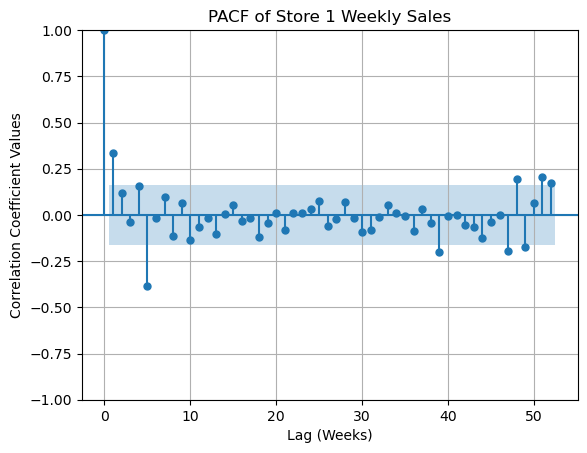

In [72]:
plot_pacf(st1_df, lags=52)
plt.title('PACF of Store 1 Weekly Sales')
plt.xlabel('Lag (Weeks)')
plt.ylabel('Correlation Coefficient Values')
plt.grid(True)

In [1]:
# A: The PACF shows most points lying within the significance band, confirming some stationarity for the data, consistent with the ACF observation.  
# There is strong lag-1 correlation at the beginning, then drops in significance
# However, there are some exceptions: 
# There are points outside the significance band towards the end of 40-50 weeks lag, 
# and there is one random exception around lag 6 which has a significant negative correlation value outside the significance band.
# Some further investigation is needed for these significant points.

---

### Modeling

**Train-test splitting**

Before fitting a model, we should train-test split. Use the first 90% of observations as training data, and use the remaining 10% as testing data. Remember -- we **do not need to shuffle the data**!

In [80]:
# no shuffling the data shuffle=False
y_train, y_test = train_test_split(st1_df, test_size=0.1, shuffle=False, random_state=123)

In [82]:
y_train.shape, y_test.shape

((128, 1), (15, 1))

**Evaluating stationarity**

Use the augmented Dickey-Fuller test to evaluate the weekly sales data, and interpret the result.

In [84]:
# adf_statistic (more negative=more stationarity) , p_value (small p<0.05 suggests stationarity) 

adf_statistic, p_value, usedlag, nobs, critical_values, icbest = adfuller(st1_df)
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)

# Critical values from Dickey-Fuller distribution tables
print('\nCritical values:')
for key, value in critical_values.items():
   print(f'\t{key}: {value}')

ADF Statistic: -5.908297957186333
p-value: 2.675979158986027e-07

Critical values:
	1%: -3.47864788917503
	5%: -2.882721765644168
	10%: -2.578065326612056


In [ ]:
# Interpret the result: 

# The ADF Statistic is -5.9, a high negative value, indicating stationarity.
# The p-value is high 2.67 >> 0.05 

# The null hypothesis (Ho) is: "The time series has a unit root (non-stationary)"
# There is evidence to fail to reject the null hypothesis due to the high p-value
# Hence, the unit root IS present and we need to difference the data. 

In [86]:
#checking diff 1

adf_statistic, p_value, usedlag, nobs, critical_values, icbest = adfuller(st1_df.diff().dropna())
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)

# Critical values from Dickey-Fuller distribution tables
print('\nCritical values:')
for key, value in critical_values.items():
   print(f'\t{key}: {value}')

ADF Statistic: -6.699469309617214
p-value: 3.9225787070768746e-09

Critical values:
	1%: -3.480118600110386
	5%: -2.8833618426136196
	10%: -2.578407034974382


In [88]:
#checking diff 2
adf_statistic, p_value, usedlag, nobs, critical_values, icbest = adfuller(st1_df.diff().diff().dropna())
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)

# Critical values from Dickey-Fuller distribution tables
print('\nCritical values:')
for key, value in critical_values.items():
   print(f'\t{key}: {value}')

ADF Statistic: -6.9450903780682856
p-value: 1.0019746180488291e-09

Critical values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


---

**Fit and evaluate an AR(1) model**

We'll start with a simple autoregressive model with order 1. In statsmodels, an autoregressive model with order $p=1$ can be implemented by instantiating and fitting an ARIMA model with order $(1,0,0)$.

Instantiate and fit your model on the training data.

In [90]:
y_train = y_train.asfreq('W')
mdl = ARIMA(y_train, order=(1, 0, 0)).fit()

In [92]:
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  128
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2165.184
Date:                Tue, 10 Dec 2024   AIC                           4336.368
Time:                        16:24:34   BIC                           4344.924
Sample:                    02-07-2010   HQIC                          4339.844
                         - 07-15-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.723e+07   9.46e+05     49.942      0.000    4.54e+07    4.91e+07
ar.L1          0.3341      0.043      7.819      0.000       0.250       0.418
sigma2        2.9e+13      0.415   6.99e+13      0.000     2.9e+13     2.9e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):               873.87
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               2.85   Skew:                             2.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.48e+28. Standard errors may be unstable.
"""

### Evaluating the model

**Store predictions**

Remember that statsmodels ARIMA models generate predictions off of **start** and **end** dates.

Generate and store predictions for the training and testing data.

In [94]:
y_train_preds = mdl.predict(start=y_train.index[0], end=y_train.index[-1])
y_test_preds = mdl.predict(start=y_test.index[0], end=y_test.index[-1])

**Mean squared error**

Use the [mean_squared_error](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mean_squared_error.html) function to identify the MSE on the testing data.

In [96]:
mse=mean_squared_error(y_test, y_test_preds)
mse

3275632194047.811

**Generate a plot of the training data, testing data, train preds, and test preds**

Create a plot showing the training data, testing data, train preds, and test preds. Make sure there are labels and legends.

> **Note**: You'll be making more similar plots. You might consider writing a function to generate your plots!

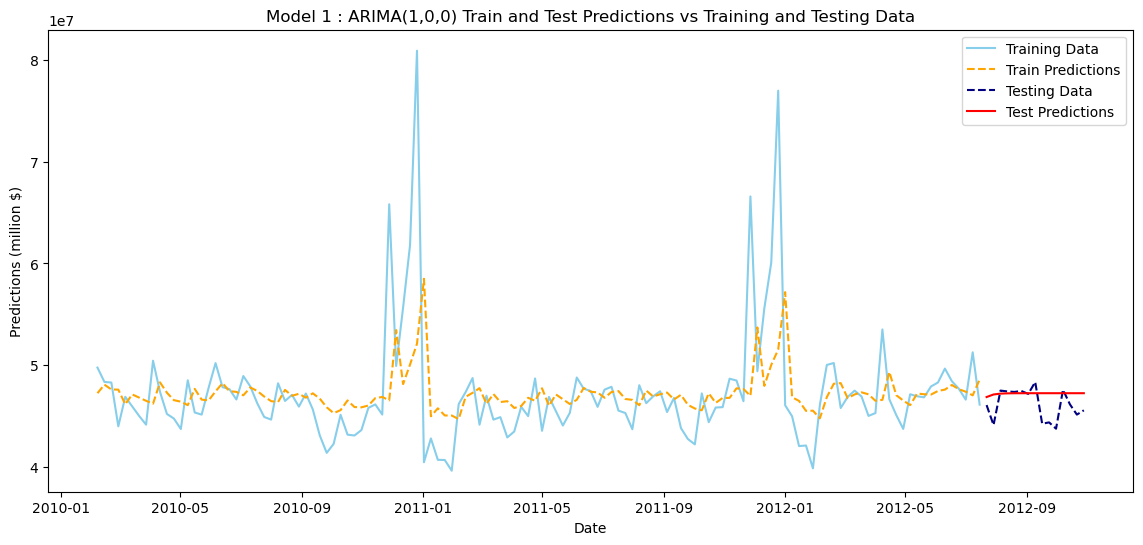

In [112]:
# def function_for_plotting():

plt.figure(figsize=(14, 6))
plt.plot(y_train, c='skyblue', label='Training Data')
plt.plot(y_train_preds, c='orange', ls='--', label='Train Predictions')
plt.plot(y_test, c='navy', ls='--', label='Testing Data')
plt.plot(y_test_preds, c='red', label='Test Predictions')
plt.title('Model 1 : ARIMA(1,0,0) Train and Test Predictions vs Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Predictions (million $)')
plt.legend();

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [ ]:
# The model did not perfom well (red line) as the test data had a range of around 4.5 -4.7 million, 
# while the model predicted towards the higher end of 4.7 million as a straight red line.
# Thus overfitting.

---

**Fit and evaluate an ARMA(2,2) model**

In statsmodels, an autoregressive moving average model with order $p=2$, $q=2$ can be implemented by instantiating and fitting an ARIMA model with order $(2,0,2)$.

Instantiate and fit your model on the training data:

In [104]:
# p,d,q = 2,0,2
mdl2 = ARIMA(y_train, order=(2, 0, 2)).fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [106]:
y_train_preds2 = mdl2.predict(start=y_train.index[0], end=y_train.index[-1])
y_test_preds2 = mdl2.predict(start=y_test.index[0], end=y_test.index[-1])

**Mean squared error**

Find the MSE of the testing data.

In [108]:
mse2=mean_squared_error(y_test, y_test_preds2)
mse2

3258435864839.983

**Generate a plot of the training data, testing data, train preds, and test preds**

As before, plot your data and predictions.

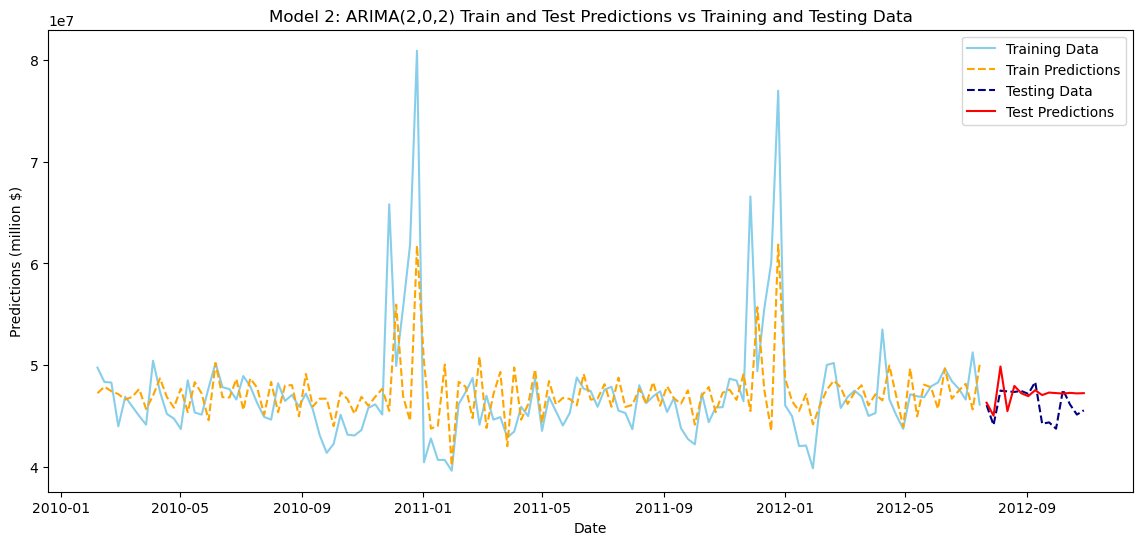

In [114]:
plt.figure(figsize=(14, 6))
plt.plot(y_train, c='skyblue', label='Training Data')
plt.plot(y_train_preds2, c='orange', ls='--', label='Train Predictions')
plt.plot(y_test, c='navy', ls='--', label='Testing Data')
plt.plot(y_test_preds2, c='red', label='Test Predictions')
plt.title('Model 2: ARIMA(2,0,2) Train and Test Predictions vs Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Predictions (million $)')
plt.legend();

**Intepretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [3]:
# A: This model did slightly better than model 1, there are smaller gaps (better fit) between the test data and test predictions in 2012-09. 
# However, as time increases further the model performance lowers to a straight line again.

---

**Fit and evaluate an ARIMA(2,1,2) model**

Instantiate and fit an ARIMA model with order $(2,1,2)$.

In [116]:
mdl3 = ARIMA(y_train, order=(2, 1, 2)).fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [119]:
y_train_preds3 = mdl3.predict(start=y_train.index[0], end=y_train.index[-1])
y_test_preds3 = mdl3.predict(start=y_test.index[0], end=y_test.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [122]:
mse3=mean_squared_error(y_test, y_test_preds3)
mse3

3707185123649.9043

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

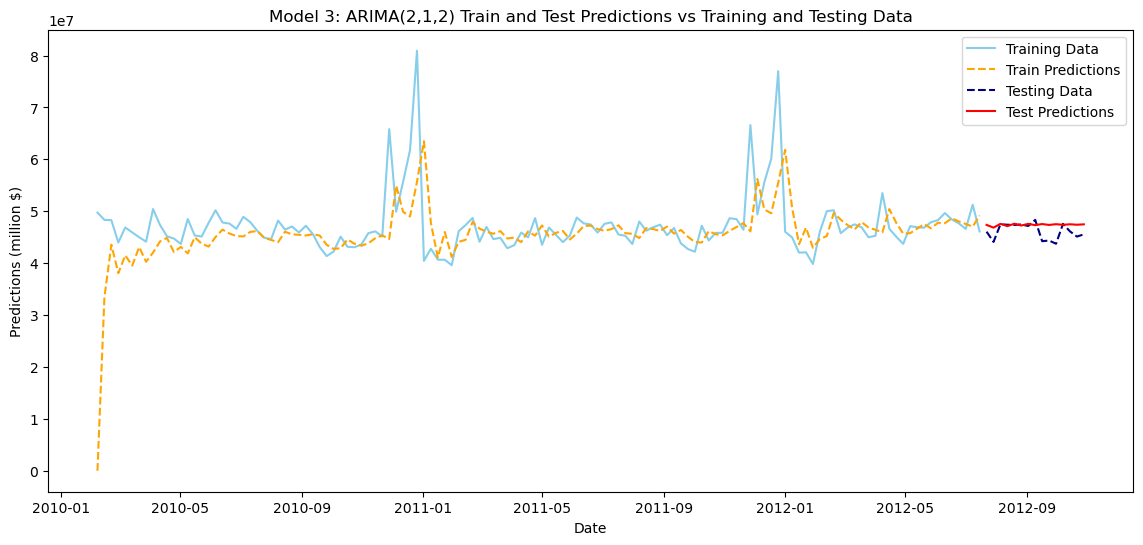

In [124]:
plt.figure(figsize=(14, 6))
plt.plot(y_train, c='skyblue', label='Training Data')
plt.plot(y_train_preds3, c='orange', ls='--', label='Train Predictions')
plt.plot(y_test, c='navy', ls='--', label='Testing Data')
plt.plot(y_test_preds3, c='red', label='Test Predictions')
plt.title('Model 3: ARIMA(2,1,2) Train and Test Predictions vs Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Predictions (million $)')
plt.legend();

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [5]:
# A: The third model ARIMA(2,1,2) has a higher mse than the previous 2 models, the training predictions were very poor at the early Date 2010-01.
# For testing data and testing predictions, the gaps seem to be close prior 2012-09 for a few months, 
# but random peaks and troughs appear after that, indicating this model also is more uncertain if further into the future. 

---

### Fit and evaluate an ARIMA(52,0,1) model

The models above use few autoregressive terms and don't do a good job of capturing the long-term trends that we know exist.

Instantiate and fit an ARIMA of order $(52,0,1)$.

In [126]:
mdl4 = ARIMA(y_train, order=(52, 0, 1)).fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [128]:
y_train_preds4 = mdl4.predict(start=y_train.index[0], end=y_train.index[-1])
y_test_preds4 = mdl4.predict(start=y_test.index[0], end=y_test.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [132]:
mse4=mean_squared_error(y_test, y_test_preds4)
mse4

2824464795177.442

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

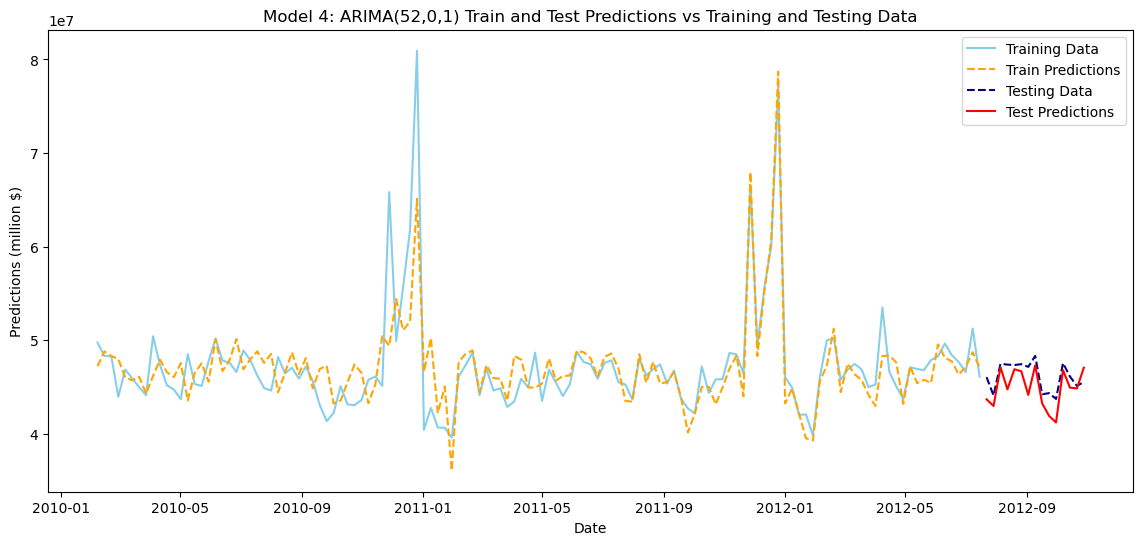

In [134]:
plt.figure(figsize=(14, 6))
plt.plot(y_train, c='skyblue', label='Training Data')
plt.plot(y_train_preds4, c='orange', ls='--', label='Train Predictions')
plt.plot(y_test, c='navy', ls='--', label='Testing Data')
plt.plot(y_test_preds4, c='red', label='Test Predictions')
plt.title('Model 4: ARIMA(52,0,1) Train and Test Predictions vs Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Predictions (million $)')
plt.legend();

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [4]:
# A: The test predictions now have peaks and troughs, however, compared to the test data, its predictions are below the actual sales.
# Thus, this model is too conservative on the sales predictions. 


---

### SARIMA Modeling

Because of the seasonality of this data, a **seasonal** ARIMA model will perform more strongly.

A SARIMA model has an ARIMA portion which behaves as we expect it to. The S part of a SARIMA model allows us to use seasonal terms. The seasonal part of a SARIMA has order $(P, D, Q)_{m}$. $m$ is the **seasonal period** -- the number of observations per season. $P$, $D$, and $Q$ are somewhat similar to the $p$, $d$, and $q$ terms in an ARIMA model, but $P$, $D$, and $Q$ actually backshift by $m$. 

You can read more about SARIMA models here:
- [PennState SARIMA notes](https://online.stat.psu.edu/stat510/lesson/4/4.1)
- [Forecasting: Principles and Practice 3rd ed.](https://otexts.com/fpp3/seasonal-arima.html)

Fit and evaluate a SARIMA model with order $(2,0,2)$ and seasonal order $(1,1,1,52)$. How well does it perform?

> **Note**: SARIMA models are implemented in statsmodels as SARIMAX - the 'X' part allows [exogenous data](https://en.wikipedia.org/wiki/Exogenous_and_endogenous_variables) to be passed in as well, though we won't specify any.
>
> The seasonal order argument is `seasonal_order`.

In [174]:
sar_mdl = SARIMAX(y_train, order=(2,0,2), seasonal_order=(1,1,1,52))
sar_res = sar_mdl.fit()
sar_mdl

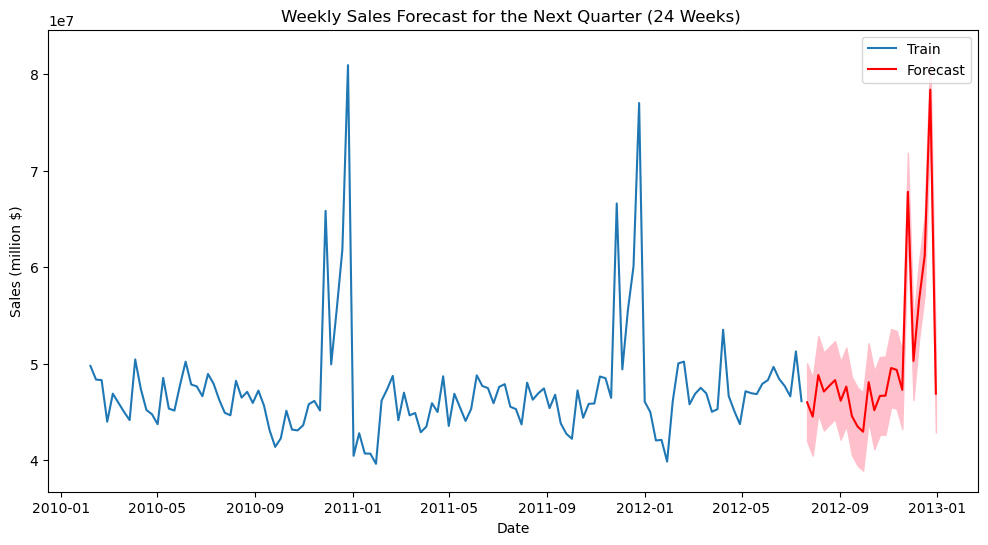

In [198]:
# Forecast
forecast_periods = 24  # Forecast next 24 weeks 
forecast = sar_res.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Train')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Weekly Sales Forecast for the Next Quarter (24 Weeks) ")
plt.xlabel("Date")
plt.ylabel("Sales (million $)")
plt.legend()
plt.show()

In [200]:
observed = y_train[-24:]
sar_mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(sar_mse)
print(f'MSE: {sar_mse}') #SARIMAX does not appear to perform better

MSE: 64144624771592.35


In [190]:
sar_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         Weekly_Sales   No. Observations:                  128
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 52)   Log Likelihood               -1209.013
Date:                              Wed, 11 Dec 2024   AIC                           2432.025
Time:                                      01:03:32   BIC                           2448.341
Sample:                                  02-07-2010   HQIC                          2438.546
                                       - 07-15-2012                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1384      0.981      0.141      0.888      -1.785       2.062
ar.L2          0.7566      0.944      0.801      0.423      -1.094       2.608
ma.L1         -0.1269      0.989     -0.128      0.898      -2.065       1.811
ma.L2         -0.7741      0.951     -0.814      0.416      -2.639       1.091
ar.S.L52       0.8911      0.555      1.606      0.108      -0.196       1.979
ma.S.L52      -0.8711      0.568     -1.534      0.125      -1.984       0.242
sigma2      4.245e+12   1.47e-12   2.89e+24      0.000    4.24e+12    4.24e+12
===================================================================================
Ljung-Box (L1) (Q):                   1.25   Jarque-Bera (JB):                25.07
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                            -0.09
Prob(H) (two-sided):                  0.63   Kurtosis:                         5.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.82e+40. Standard errors may be unstable.
"""

In [186]:
# Mean squared error comparable to Model 1.
print("MSEs:")
print(f" Model 1 : {mse}")
print(f" Model 2 : {mse2}")
print(f" Model 3 : {mse3}")
print(f" Model 4 : {mse4}")
print(f" Model 5 : {sar_mse}")

MSEs:
 Model 1 : 68152982399167.98
 Model 2 : 3258435864839.983
 Model 3 : 3707185123649.9043
 Model 4 : 2824464795177.442
 Model 5 : 64144624771592.35
